# This notebook test full workflow while using MLRun packgers

This notebook will test :

1. Loging object to MLRun such as: `pd.DataFrame, np.ndarray, str and list`.
2. Unpack `pd.DataFrame, np.ndarray, str and list` and compare them to the original values.
3. Logging object to MLRun such as: `pd.DataFrame, np.ndarray, string, list` with non default artifact type and file format.
4. Unpack outputs from step 3 and validate the expcted values are matched to the original 
5. Pack Custom packager that pack a zip file path to a zip file
6. Unpack Custom packager

In [1]:
import mlrun
import pandas as pd
import numpy as np
import os
import shutil

In [2]:
project = mlrun.get_or_create_project("test-pack",'./context',user_project=True)

> 2023-12-27 09:20:56,335 [info] Created and saved project: {'name': 'test-pack-avia', 'from_template': None, 'overwrite': False, 'context': './context', 'save': True}
> 2023-12-27 09:20:56,338 [info] Project created successfully: {'project_name': 'test-pack', 'stored_in_db': True}


## 1.  Loging object to MLRun such as: `pd.DataFrame, np.array, string, list`

Expcted logging result:
* `pd.DataFrame` - as dataset artifact type and default parquet file
* `np.nparray` - as artifact artifact type and default npy file
* `str` - as a run result 
* `list` as a run result

In [3]:
%%writefile ./context/generate-outputs.py
import numpy as np
import pandas as pd


def generate_outputs():
    df_true = pd.DataFrame(
        data={
            **{f"column_{i}": np.arange(0, 1000) for i in range(1, 10)},
        },
    ).set_index(keys=["column_7", "column_8", "column_9"])

    np_example = np.array(
        [[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]]
    )

    example_string = "Example_String"

    example_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, "A"]
    return df_true, np_example, example_string, example_list


Writing ./context/generate-outputs.py


In [4]:
project.set_function("./generate-outputs.py",name='generate-outputs',kind='job',image='mlrun/mlrun',handler='generate_outputs')

In [5]:
outputs_run = project.run_function("generate-outputs",returns=["df","np_example","example_string","example_list"])

> 2023-12-27 09:20:56,495 [info] Storing function: {'name': 'generate-outputs-generate-outputs', 'uid': '5dcef61470c544c085040391fc67021a', 'db': 'http://mlrun-api:8080'}
> 2023-12-27 09:20:56,773 [info] Job is running in the background, pod: generate-outputs-generate-outputs-qxf5k
> 2023-12-27 09:20:59,832 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 5dcef61470c544c085040391fc67021a -p test-pack-avia', 'logs_cmd': 'mlrun logs 5dcef61470c544c085040391fc67021a -p test-pack-avia'}
> 2023-12-27 09:20:59,832 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.app-lab-2-b688.iguazio-cd2.com/mlprojects/test-pack-avia/jobs/monitor/5dcef61470c544c085040391fc67021a/overview'}
> 2023-12-27 09:20:59,833 [info] Run execution finished: {'status': 'completed', 'name': 'generate-outputs-generate-outputs'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
test-pack-avia,...fc67021a,0,Dec 27 09:20:59,completed,generate-outputs-generate-outputs,v3io_user=aviakind=jobowner=aviamlrun/client_version=1.6.0-rc17mlrun/client_python_version=3.9.16host=generate-outputs-generate-outputs-qxf5k,,,"example_string=Example_Stringexample_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 'A']",dfnp_example


> 2023-12-27 09:21:09,923 [info] Run execution finished: {'status': 'completed', 'name': 'generate-outputs-generate-outputs'}


**Validate Run Result**

In [6]:
df_outputs_run = project.get_store_resource(outputs_run.outputs["df"])
assert df_outputs_run.kind == 'dataset'
assert df_outputs_run.target_path.endswith("parquet")

In [7]:
df_outputs_run = project.get_store_resource(outputs_run.outputs["np_example"])
assert df_outputs_run.kind == 'artifact'
assert df_outputs_run.target_path.endswith("npy")

In [8]:
assert outputs_run.outputs["example_string"]=='Example_String'
assert outputs_run.outputs["example_list"]==[1, 2, 3, 4, 5, 6, 7, 8, 9, 'A']

## 2. Unpack `pd.DataFrame, np.ndarray, str and list` and compare them to the original values.

Expected result - 
* run the function without any assertion errors and validate the numpy and pandas are unpacked as expcted 

In [9]:
%%writefile ./context/generate-inputs.py
import numpy as np
import pandas as pd


def generate_inputs(np_example: np.ndarray, df: pd.DataFrame):
    df_true = pd.DataFrame(
        data={
            **{f"column_{i}": np.arange(0, 1000) for i in range(1, 10)},
        },
    ).set_index(keys=["column_7", "column_8", "column_9"])

    # compare dataframe unpack
    assert df_true.compare(df).shape == (0, 0)

    # compare dataframe unpack
    np_true = np.array(
        [[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]]
    )
    assert np.array_equal(np_true, np_example)

    return "OK"

Writing ./context/generate-inputs.py


In [10]:
project.set_function("./generate-inputs.py",name='generate-inputs',kind='job',image='mlrun/mlrun',handler='generate_inputs')

In [11]:
df = outputs_run.outputs["df"]
array_np = outputs_run.outputs["np_example"]


In [12]:
inputs_run = project.run_function("generate-inputs",inputs={"df":df,"np_example":array_np},returns=["state"])

> 2023-12-27 09:21:10,268 [info] Storing function: {'name': 'generate-inputs-generate-inputs', 'uid': 'cb4f1872080a41bdacc3286162504c65', 'db': 'http://mlrun-api:8080'}
> 2023-12-27 09:21:10,570 [info] Job is running in the background, pod: generate-inputs-generate-inputs-l6jlj
> 2023-12-27 09:21:13,487 [info] downloading v3io:///projects/test-pack-avia/artifacts/generate-outputs-generate-outputs/0/np_example.npy to local temp file
> 2023-12-27 09:21:14,135 [info] To track results use the CLI: {'info_cmd': 'mlrun get run cb4f1872080a41bdacc3286162504c65 -p test-pack-avia', 'logs_cmd': 'mlrun logs cb4f1872080a41bdacc3286162504c65 -p test-pack-avia'}
> 2023-12-27 09:21:14,135 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.app-lab-2-b688.iguazio-cd2.com/mlprojects/test-pack-avia/jobs/monitor/cb4f1872080a41bdacc3286162504c65/overview'}
> 2023-12-27 09:21:14,135 [info] Run execution finished: {'status': 'completed', 'name': 'generate-inputs-generate-inputs'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
test-pack-avia,...62504c65,0,Dec 27 09:21:13,completed,generate-inputs-generate-inputs,v3io_user=aviakind=jobowner=aviamlrun/client_version=1.6.0-rc17mlrun/client_python_version=3.9.16host=generate-inputs-generate-inputs-l6jlj,dfnp_example,,state=OK,


> 2023-12-27 09:21:21,698 [info] Run execution finished: {'status': 'completed', 'name': 'generate-inputs-generate-inputs'}


**Validate Run Result**

In [13]:
assert inputs_run.outputs["state"] == "OK"

## 3. Logging object to MLRun such as: `pd.DataFrame, np.ndarray, string, list` with non default artifact type and file format.

Excpected output result - 

* df_pkl as an artifact artifact type and pickle file
* df_csv as an artifact artifact type and a csv file
* np_csv as an artifact artifact type and a csv file

In [14]:
%%writefile ./context/generate-outputs-non-default.py
import numpy as np
import pandas as pd
from numpy import asarray


def generate_outputs():
    df_true = pd.DataFrame(
        data={
            **{f"column_{i}": np.arange(0, 1000) for i in range(1, 10)},
        },
    ).set_index(keys=["column_7", "column_8", "column_9"])

    np_example = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

    df_pkl = df_true
    df_csv = df_true
    np_csv = np_example
    return df_pkl, df_csv, np_csv

Writing ./context/generate-outputs-non-default.py


In [15]:
project.set_function("./generate-outputs-non-default.py",name='generate-outputs-non-default',kind='job',image='mlrun/mlrun',handler='generate_outputs')

In [16]:
non_defualt_run = project.run_function('generate-outputs-non-default',returns=["df_pkl:object",
                                                                               {"key":"df_csv","artifact_type":"file","file_format":"csv"},
                                                                               {"key":"np_csv","file_format":"csv"}])

> 2023-12-27 09:21:21,849 [info] Storing function: {'name': 'generate-outputs-non-default-generate-outputs', 'uid': '152cdd9a338a4ee89686b02e6d91cab9', 'db': 'http://mlrun-api:8080'}
> 2023-12-27 09:21:22,189 [info] Job is running in the background, pod: generate-outputs-non-default-generate-outputs-2t2jq
> 2023-12-27 09:21:25,282 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 152cdd9a338a4ee89686b02e6d91cab9 -p test-pack-avia', 'logs_cmd': 'mlrun logs 152cdd9a338a4ee89686b02e6d91cab9 -p test-pack-avia'}
> 2023-12-27 09:21:25,282 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.app-lab-2-b688.iguazio-cd2.com/mlprojects/test-pack-avia/jobs/monitor/152cdd9a338a4ee89686b02e6d91cab9/overview'}
> 2023-12-27 09:21:25,282 [info] Run execution finished: {'status': 'completed', 'name': 'generate-outputs-non-default-generate-outputs'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
test-pack-avia,...6d91cab9,0,Dec 27 09:21:24,completed,generate-outputs-non-default-generate-outputs,v3io_user=aviakind=jobowner=aviamlrun/client_version=1.6.0-rc17mlrun/client_python_version=3.9.16host=generate-outputs-non-default-generate-outputs-2t2jq,,,,df_pkldf_csvnp_csv


> 2023-12-27 09:21:33,314 [info] Run execution finished: {'status': 'completed', 'name': 'generate-outputs-non-default-generate-outputs'}


**Validate Run outputs**

In [17]:
df_pkl_non_defualt_run = project.get_store_resource(non_defualt_run.outputs["df_pkl"])
assert df_pkl_non_defualt_run.kind == 'artifact'
assert df_pkl_non_defualt_run.target_path.endswith("pkl")

In [18]:
df_csv_non_defualt_run = project.get_store_resource(non_defualt_run.outputs["df_csv"])
assert df_csv_non_defualt_run.kind == 'artifact'
assert df_csv_non_defualt_run.target_path.endswith("csv")

In [19]:
np_csv_non_defualt_run = project.get_store_resource(non_defualt_run.outputs["np_csv"])
assert np_csv_non_defualt_run.kind == 'artifact'
assert np_csv_non_defualt_run.target_path.endswith("csv")

## 4. Unpack outputs from step 3 and validate the expcted values are matched to the original 

Excpted result -
* run without assertion errors.

In [20]:
%%writefile ./context/generate-inputs-non-defaults.py
import numpy as np
import pandas as pd
from numpy import asarray


def generate_inputs(df_pkl: pd.DataFrame, df_csv: pd.DataFrame, np_csv: np.ndarray):
    df_true = pd.DataFrame(
        data={
            **{f"column_{i}": np.arange(0, 1000) for i in range(1, 10)},
        },
    ).set_index(keys=["column_7", "column_8", "column_9"])
    # compare dataframe unpack
    assert df_true.compare(df_pkl).shape == (0, 0)
    assert df_true.compare(df_csv).shape == (0, 0)
    # compare dataframe unpack
    np_true = asarray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    assert np.array_equal(np_true, np_csv)

    return "OK"


Writing ./context/generate-inputs-non-defaults.py


In [21]:
df_pkl = non_defualt_run.outputs["df_pkl"]
df_csv = non_defualt_run.outputs["df_csv"]
np_csv = non_defualt_run.outputs["np_csv"]

In [22]:
project.set_function("./generate-inputs-non-defaults.py",name='generate-inputs-non-defaults',kind='job',image='mlrun/mlrun',handler='generate_inputs')

In [23]:
inputs_run_non_defualt = project.run_function("generate-inputs-non-defaults",inputs={"df_pkl":df_pkl,"df_csv":df_csv,"np_csv":np_csv},returns=["state"])

> 2023-12-27 09:21:33,532 [info] Storing function: {'name': 'generate-inputs-non-defaults-generate-inputs', 'uid': '9fb13cfd74d14947a007fe7b6dc375ee', 'db': 'http://mlrun-api:8080'}
> 2023-12-27 09:21:33,756 [info] Job is running in the background, pod: generate-inputs-non-defaults-generate-inputs-x6zxm
> 2023-12-27 09:21:36,675 [info] downloading v3io:///projects/test-pack-avia/artifacts/generate-outputs-non-default-generate-outputs/0/df_pkl.pkl to local temp file
> 2023-12-27 09:21:36,699 [info] downloading v3io:///projects/test-pack-avia/artifacts/generate-outputs-non-default-generate-outputs/0/df_csv.csv to local temp file
> 2023-12-27 09:21:36,726 [info] downloading v3io:///projects/test-pack-avia/artifacts/generate-outputs-non-default-generate-outputs/0/np_csv.csv to local temp file

> 2023-12-27 09:21:36,808 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 9fb13cfd74d14947a007fe7b6dc375ee -p test-pack-avia', 'logs_cmd': 'mlrun logs 9fb13cfd74d14947a007fe7b6dc375e

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
test-pack-avia,...6dc375ee,0,Dec 27 09:21:36,completed,generate-inputs-non-defaults-generate-inputs,v3io_user=aviakind=jobowner=aviamlrun/client_version=1.6.0-rc17mlrun/client_python_version=3.9.16host=generate-inputs-non-defaults-generate-inputs-x6zxm,df_pkldf_csvnp_csv,,state=OK,


> 2023-12-27 09:21:42,878 [info] Run execution finished: {'status': 'completed', 'name': 'generate-inputs-non-defaults-generate-inputs'}


## 5. Run packing and unpacking in pipeline 

Expcted result - status is ok

In [24]:
%%writefile ./context/workflow.py
import mlrun
from kfp import dsl
from mlrun import get_or_create_ctx

@dsl.pipeline(
    name="test-packager-pipeline",
    description="predicting stock prices using yahoo api with sentiment analysis"
)

def kfpipeline():

    ctx = get_or_create_ctx(name='kfp-context')

    kfp_project = mlrun.get_current_project()

    kfp_generate_outputs_run = mlrun.run_function("generate-outputs",
                                              returns=["df","np_example","example_string","example_list"])

    kfp_project.run_function("generate-inputs", inputs={"df":kfp_generate_outputs_run.outputs["df"], "np_example":kfp_generate_outputs_run.outputs["np_example"]}, returns=["state"])

Writing ./context/workflow.py


In [25]:
# Register the workflow file:
workflow_name = "test-packager-workflow"
project.set_workflow(name=workflow_name, workflow_path="workflow.py")
project.save()

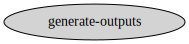

In [ ]:
project.run(workflow_name,
            watch=True)

## 6. Pack Custom packager that pack a zip file path to a zip file

Expcted result -
* to pack a string as an artifact type artifact and as a zip file

In [ ]:
os.makedirs('./custom_pack/')

Writing custome object file

In [ ]:
%%writefile ./custom_pack/custom.py
import os
import tempfile
import pathlib
from typing import Tuple

from mlrun import ArtifactType
from mlrun.artifacts import Artifact
from mlrun.datastore import DataItem
from mlrun.errors import MLRunInvalidArgumentError
from mlrun.package import DefaultPackager
from mlrun.package.utils import DEFAULT_ARCHIVE_FORMAT, ArchiveSupportedFormat


class StringPackager(DefaultPackager):
    """
    ``builtins.str`` packager.
    """

    PACKABLE_OBJECT_TYPE = str
    DEFAULT_PACKING_ARTIFACT_TYPE = ArtifactType.FILE
    DEFAULT_UNPACKING_ARTIFACT_TYPE = ArtifactType.PATH

    def pack_file(
        self, obj: str, key: str, archive_format: str = DEFAULT_ARCHIVE_FORMAT
    ) -> Tuple[Artifact, dict]:
        """
        Pack a zip value content (pack the file or directory in that path).

        :param obj:            The zip object to pack.
        :param key:            The key to use for the artifact.
        :param archive_format: The archive format to use in case the path is of a directory. Default is zip.

        :return: The packed artifact and instructions.
        """
        # Proceed by path type (file or directory):
        if os.path.isfile(obj):
            # Create the artifact:
            artifact = Artifact(key=key, src_path=os.path.abspath(obj))
            instructions = {"archive_format": "zip", "is_directory": True}
        else:
            raise MLRunInvalidArgumentError(
                f"The given path is not a file nor a directory: '{obj}'"
            )

        return artifact, instructions

    def unpack_file(
        self, data_item: DataItem, is_directory: bool = False, archive_format: str = None
    ) -> str:
        """
        Unpack a data item representing a path string. If the path is of a file, the file is downloaded to a local
        temporary directory and its path is returned. If the path is of a directory, the archive is extracted and the
        directory path extracted is returned.

        :param data_item:      The data item to unpack.
        :param is_directory:   Whether the path should be treated as a file or a directory. Files (even archives like
                               zip) won't be extracted.
        :param archive_format: The archive format to use in case the path is of a directory. Default is None - will be
                               read by the archive file extension.

        :return: The unpacked string.
        """
        # Get the file to a local temporary directory:
        path = data_item.local()

        # Mark the downloaded file for future clear:
        self.add_future_clearing_path(path=path)

        # If it's not a directory, return the file path. Otherwise, it should be extracted according to the archive
        # format:
        if not is_directory:
            return path

        # Get the archive format by the file extension:
        if archive_format is None:
            archive_format = ArchiveSupportedFormat.match_format(path=path)
        if archive_format is None:
            raise MLRunInvalidArgumentError(
                f"Archive format of {data_item.key} ('{''.join(pathlib.Path(path).suffixes)}') is not supported. "
                f"Supported formats are: {' '.join(ArchiveSupportedFormat.get_all_formats())}"
            )

        # Extract the archive:
        archiver = ArchiveSupportedFormat.get_format_handler(fmt=archive_format)
        directory_path = archiver.extract_archive(
            archive_path=path, output_path=os.path.dirname(path)
        )

        # Mark the extracted content for future clear:
        self.add_future_clearing_path(path=directory_path)

        # Return the extracted directory path:
        return directory_path

In [ ]:
%%writefile ./custom_pack/test-custom.py
import os
import shutil
import time

from custom import StringPackager


def func_custom():
    os.makedirs("./files/")
    with open("./files/test_1.txt", "w") as file:
        file.write("file1")
        file.close()

    with open("./files/test_2.txt", "w") as file:
        file.write("file2")
        file.close()

    with open("./files/test_3.txt", "w") as file:
        file.write("file3")
        file.close()

    shutil.make_archive("test", "zip", "./files/")
    return "./test.zip"

In [ ]:
%%writefile ./custom_pack/test-custom-unpack.py
import os
import shutil
import time

from custom import StringPackager

from mlrun import ArtifactType


def func_custom(zip_file: str):
    print(zip_file)
    with open(f"{zip_file}/test_1.txt", "r") as file:
        read = file.read()
        assert read == "file1"
        file.close()

    with open(f"{zip_file}/test_2.txt", "r") as file:
        read = file.read()
        assert read == "file2"
        file.close()

    with open(f"{zip_file}/test_3.txt", "r") as file:
        read = file.read()
        assert read == "file3"
        file.close()

    return "Completed"

In [ ]:
project.add_custom_packager(packager="custom.StringPackager",is_mandatory=True)

In [ ]:
shutil.make_archive('test','zip','./custom_pack/')

In [ ]:
source_art = project.log_artifact("source-zip",local_path='./test.zip')

In [ ]:
project.set_source(source_art.target_path,pull_at_runtime=True)

In [ ]:
project.save()

In [ ]:
func = project.set_function("./test-custom.py",name="test-custom",kind='job',image='mlrun/mlrun',handler='func_custom',with_repo=True)

In [ ]:
test_func = func.run(returns=["test_zip:file"])

## 6. Unpack Custom packager
Expcted result -
* unpack the zip file to the temp folder and check the file content and run without assert issue

In [ ]:
func = project.set_function("./test-custom-unpack.py",name="test-custom-unpack",kind='job',image='mlrun/mlrun',handler='func_custom',with_repo=True)

In [ ]:
input_zip = test_func.outputs["test_zip"]

In [ ]:
func.run(inputs={"zip_file":input_zip},returns=["State"])

In [ ]:
db = mlrun.get_run_db()

In [ ]:
db.delete_project(name=project.name,deletion_strategy='cascade')

In [ ]:
shutil.rmtree('./context/')

In [ ]:
shutil.rmtree('./custom_pack/')

In [ ]:
os.remove('./test.zip')